# Tutorial: using Docta to curate your tabular data in seconds

This tutorial serves to help readers hand on using docta to detect label errors or rare patterns in a tabular dataset.

**Outline:**

* Basic set up;

* Detecting label errors in your tabular data with Docta;

* Detecting rare patterns in your tabular data with Docta.


### Section 1: Basic set up

#### 1.1 Set path so that modules from other foloders can be loaded

In [1]:
import sys
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
os.chdir('..')
o_path = os.getcwd()
sys.path.append(o_path)

#### 1.2 Iris data

We will adopt the popular Iris dataset for illustration.

**Basic information**
The Iris data includes three iris species with 50 samples each as well as some properties about each flower. Here is a display of the main features/labels of the iris dataset.

In [2]:
import pandas as pd
base_path = 'demo_imgs/noisy_tabular/'
clean_iris = pd.read_csv(base_path + 'clean_Iris.csv')
clean_iris.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,83,5.8,2.7,3.9,1.2,Iris-versicolor
1,132,7.9,3.8,6.4,2.0,Iris-virginica
2,93,5.8,2.6,4.0,1.2,Iris-versicolor
3,29,5.2,3.4,1.4,0.2,Iris-setosa
4,12,4.8,3.4,1.6,0.2,Iris-setosa


The column ``Id`` indicates the raw index of the sample in the [official Iris dataset](https://archive.ics.uci.edu/dataset/53/iris). As displayed in the above table, there are four key compenents (faetures) for categorizing the species of the iris flower: ``SepalLengthCm``, ``SepalWidthCm``, ``PetalLengthCm``, ``PetalWidthCm``.

#### 1.3 Prepare an imperfect dataset for Docta's treatment

The following function gives an example pipeline for preparing a dataset for Docta treatment.

In [3]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

def process_csv(file_path, e=0.2):
    """
    Input:
      file_path: a raw file path of your csv file that you want to process
      e: the percentage of label errors to simulate
      (in this Iris data, we use the clean label to simulate label errors)
    Output:
      df: a processed csv files with label errors,
          each column denotes a kind of feature (changed to nemerical ones if not),
          except for the last one which is the (noisy) target column.
      clean_label: this is the clean target reserved for checking the Docta performances
    """
    # Load your data
    df = pd.read_csv(file_path)

    # (1) Rename the last column to 'clean_target'
    df.rename(columns={df.columns[-1]: 'clean_target'}, inplace=True)

    # (2) If 'clean_target' column is not of integer type, convert it
    if df['clean_target'].dtype != 'int':
        le = LabelEncoder()
        df['clean_target'] = le.fit_transform(df['clean_target'])

    # (3) Convert other columns to numerical values if they are not already
    for col in df.columns[:-1]:  # Exclude the last column
        if df[col].dtype == 'object':  # If the column has text
            df[col] = le.fit_transform(df[col])  # Convert text to integer

    # (4) Add a new 'target' column
    n_unique = df['clean_target'].nunique()
    def generate_target(val):
        rand_val = np.random.random()
        if rand_val < e:
            new_val = np.random.choice([i for i in range(n_unique) if i != val])
        else:
            new_val = val
        return new_val

    df['target'] = df['clean_target'].apply(generate_target)
    accuracy = (df['target'] == df['clean_target']).mean() * 100
    # Print the accuracy
    print(f"Label error rate: {100 - accuracy:.2f}%")
    clean_label = df['clean_target'].tolist()
    # Remove the clean label
    df = df.drop(columns=['Id', 'clean_target'], axis=1)

    return df, clean_label

Get a simulated dataframe based on the Iris data with label errors.

In [4]:
noisy_df, clean_label = process_csv(base_path + 'clean_Iris.csv', e=0.25)

Label error rate: 29.33%


Save the file to a csv file for Docta treatment

In [5]:
noisy_df.to_csv(base_path + 'noisy_Iris.csv', index=False)

Take a look at the simulated imperfect Iris data

In [6]:
noisy_df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,target
0,5.8,2.7,3.9,1.2,2
1,7.9,3.8,6.4,2.0,2
2,5.8,2.6,4.0,1.2,1
3,5.2,3.4,1.4,0.2,0
4,4.8,3.4,1.6,0.2,0


### Section 2: Diagnose label errors in the dataset

#### 2.1 What are samples with label errors?

A figure below illustrates what are samples with label errors.

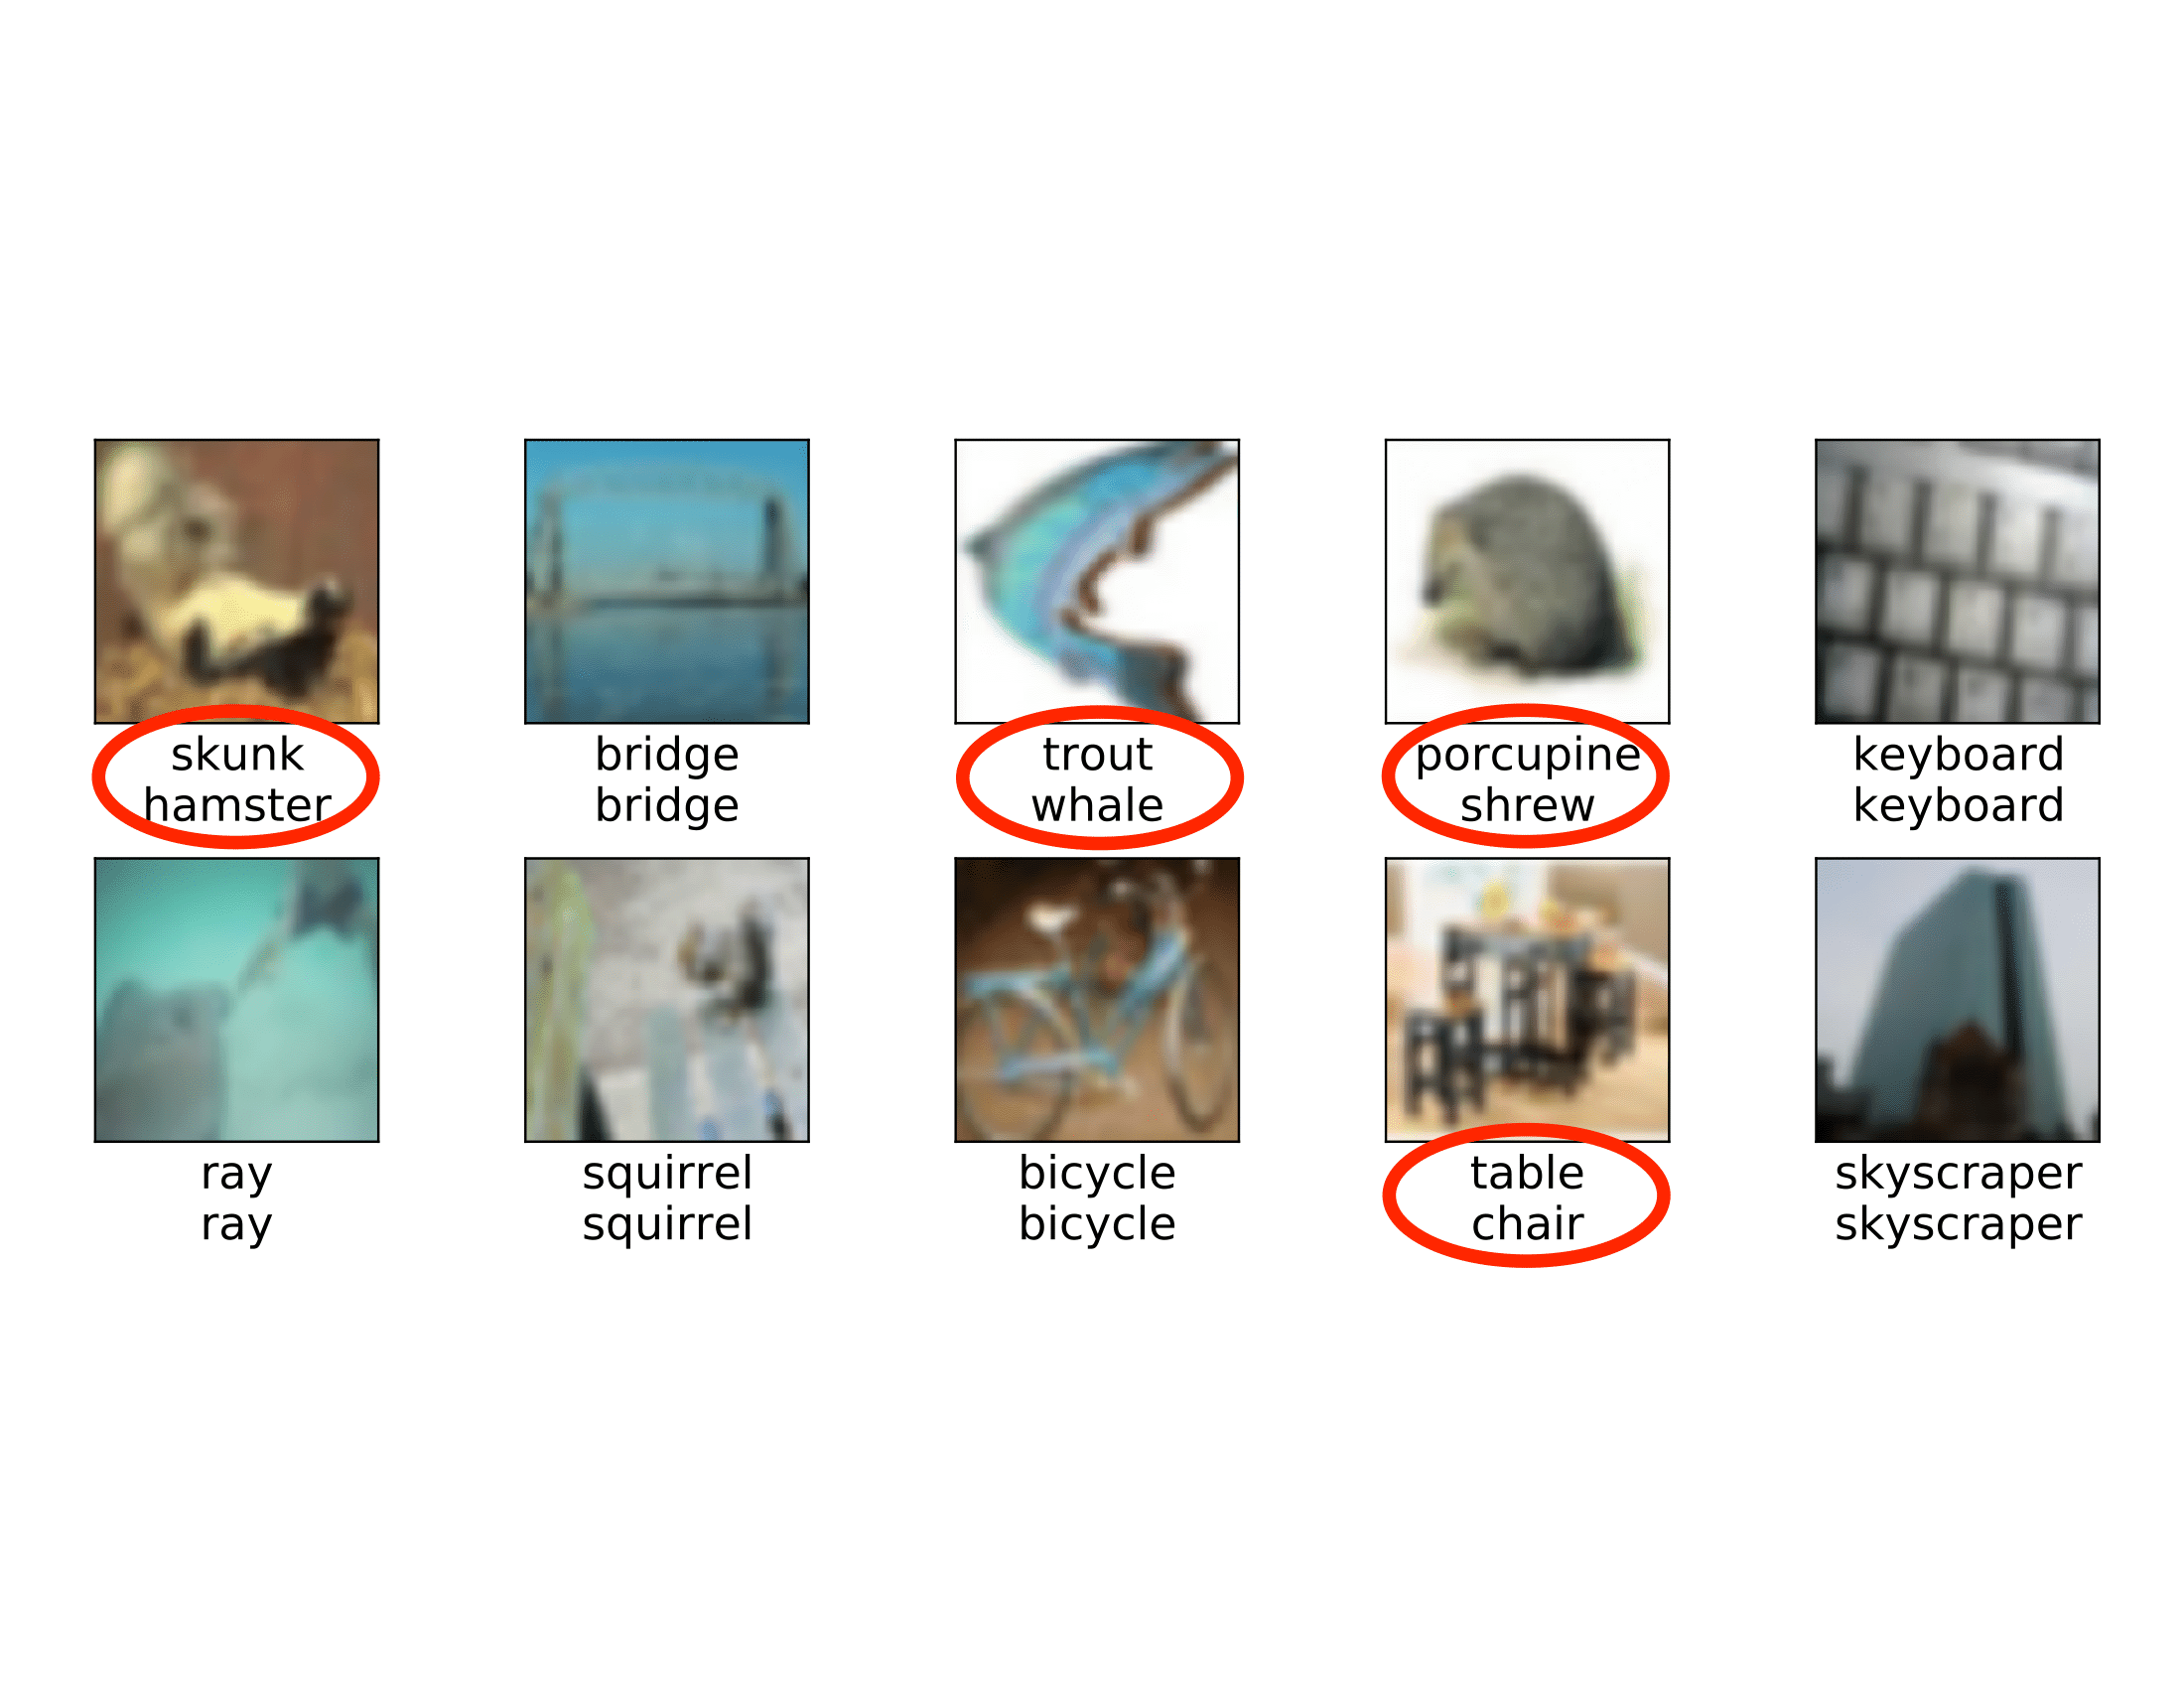

In [7]:
from IPython.display import Image
display(Image(filename='demo_imgs/label_error.png', width = 600, height = 400))

The figure above includes 10 selected [CIFAR-100N](https://github.com/UCSC-REAL/cifar-10-100n) images with ground-truth labels (first row in text) and human annotated labels (second row in text). Images with red-circled text indicate that their human annotations differ from the ground-truth label. Thus, there exists label error in images with red-circled labels.

**Don't worry about label errors in your data. Docta can help you detecting them!**

#### 2.2 Label error detection and curation for your tabular data with Docta

In [8]:
%run ./tools/diagnose_tabular.py

==== Docta: Doctor for your data. Current version: 0.0 ====
Tabular_train
Tabular-data load finished
Detecting label errors with simifeat.
Estimating consensus patterns...


100%|██████████| 50/50 [00:00<00:00, 177.39it/s]


Estimating consensus patterns... [Done]
Use cpu to solve equations


100%|██████████| 1501/1501 [00:03<00:00, 427.72it/s]


Solve equations... [Done]
Use SimiFeat-rank to detect label errors.


100%|██████████| 51/51 [00:00<00:00, 1124.14it/s]

[SimiFeat] We find 107 corrupted instances from 150 instances
Report saved to ./results/Tabular_train/label_error_Tabular_train_diagnose_report.pt



#### 2.3 Walk through the diagnose report given by Docta

Take a look at the Docta cured/corrected labels

In [9]:
print(f"Load docta cured labels from {report_path}")
cured_labels = torch.load(report_path)

Load docta cured labels from ./results/Tabular_train/label_error_Tabular_train_diagnose_report.pt


**Check the label error detection results**

For each row, it contains the information of (**sample index & the probability of containing label error**)

In [10]:
detected = cured_labels.detection['label_error']
print(detected[0]) # See what each element looks like (sample index,the probability of containing label error)

[47, 0.9807692307692307]


In [11]:
detected_idx = [detected[i][0] for i in range(len(detected))]

Find out indexes samples with label errors by referring to the ground-truth data

In [12]:
noisy_label = noisy_df['target'].tolist()
wrong_idx = [i for i, (x, y) in enumerate(zip(clean_label, noisy_label)) if x != y]

In [13]:
set_grountruth = set(wrong_idx)

**Option 1: filtering samples with label errors to prepare a cleaner data**

Note that the raw noisy training data can be denoted below 

* X_noisy: feature;

* y_noisy: the noisy labels of samples;

In [14]:
X_noisy = noisy_df.drop('target', axis=1).to_numpy()
y_noisy = noisy_df['target'].to_numpy()

The following function takes the docta report, error_report, and train data as input, outputs the filtered X_train, y_train

* X_noisy_filtered: features of samples with correct labels (in the view of Docta);

* y_noisy_filtered: corresponding labels;

In [15]:
def filter_arrays(X_noisy, y_noisy, error_report, thres=0.8):
    # Gather indices where second element in error report > thres
    store_idx = [a for a, b in error_report if b > thres]
    all_idx = range(len(y_noisy))
    filtered_idx = [elem for elem in all_idx if elem not in store_idx]
    # Filter X_noisy and y_noisy with indices in store_idx
    X_noisy_filtered = X_noisy[filtered_idx]
    y_noisy_filtered = y_noisy[filtered_idx]
    print(f"Docta filtered {len(store_idx)} out of {len(y_noisy)} samples that are potentially containing label errors")
    return X_noisy_filtered, y_noisy_filtered

In [16]:
X_noisy_filtered, y_noisy_filtered = filter_arrays(X_noisy, y_noisy, error_report=detected, thres=0.8)

Docta filtered 94 out of 150 samples that are potentially containing label errors


**Check the result of label curation**

For each row, it contains the information of (**sample index & Docta suggested label & the probability of containing label error**)

In [17]:
cured = cured_labels.curation['label_curation']
print(cured[0]) # See what each element looks like

[47, 2, 0.7957184325108854]


**Option 2: Correcting/Curating samples with label errors to prepare a cleaner data**

The following function takes the docta report, labels, and noisy train labels as input, outputs the curated y_train:

* y_docta: docta curated labels;

In [18]:
# This function takes the docta report, cured labels, and y_noisy as input, outputs a corrected y_train
import numpy as np
def cure_y_train(y_noisy, cured_report, thres = 0.8):
    y_noisy_copy = np.copy(y_noisy)
    cnt = 0
    for report in cured_report:
        a, b, c = report
        if c > thres:
            y_noisy_copy[a] = b
            cnt += 1
    return y_noisy_copy, cnt

In [19]:
docta_labels, n_cured_labels = cure_y_train(noisy_df['target'].tolist(), cured, thres = 0.8)
noisy_df['docta_labels'] = docta_labels
print(f"Docta cured {n_cured_labels} potential label errors!")
noisy_df.head()

Docta cured 46 potential label errors!


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,target,docta_labels
0,5.8,2.7,3.9,1.2,2,1
1,7.9,3.8,6.4,2.0,2,2
2,5.8,2.6,4.0,1.2,1,1
3,5.2,3.4,1.4,0.2,0,0
4,4.8,3.4,1.6,0.2,0,0


**Take a look at the confusion matrix comparisons**

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
noisy_cm = confusion_matrix(clean_label, y_noisy)
docta_cm = confusion_matrix(clean_label, docta_labels)
print(f"The confusion matrix between clean labels and the raw noisy labels is:\n{noisy_cm}\nAnd number of label errors is {int(len(clean_label)*(1-accuracy_score(clean_label, y_noisy)))}")
print("-----------"*7)
print(f"The confusion matrix between clean labels and the docta curated labels is:\n{docta_cm}\nAnd number of label errors is {int(len(clean_label)*(1-accuracy_score(clean_label, docta_labels)))}")

The confusion matrix between clean labels and the raw noisy labels is:
[[33  7 10]
 [ 7 39  4]
 [14  2 34]]
And number of label errors is 44
-----------------------------------------------------------------------------
The confusion matrix between clean labels and the docta curated labels is:
[[47  1  2]
 [ 3 38  9]
 [ 3  5 42]]
And number of label errors is 23


#### 2.4 Visualization of the differences between clean and noisy data

**SepalLengthCm v.s. SepalWidthCm** (Left: Clean data; Middle: Docta cured data; Right: Noisy data)

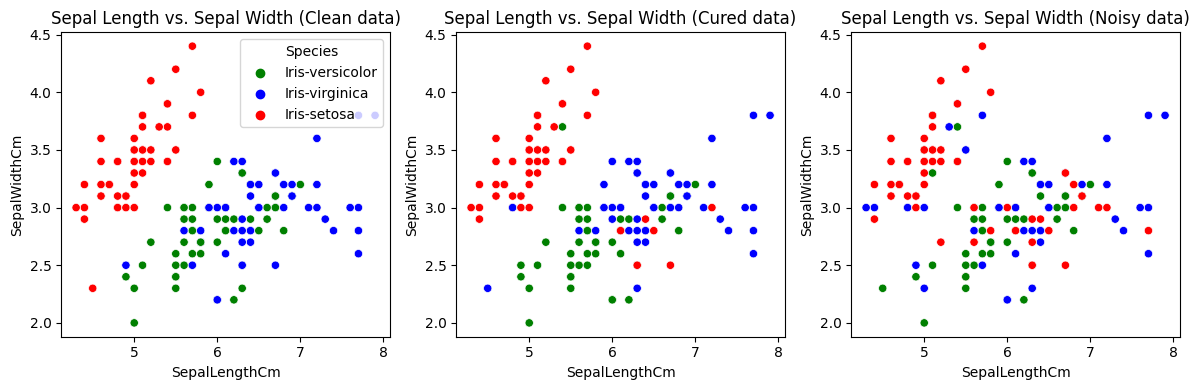

In [21]:
color_mapping = {"Iris-setosa": "red", "Iris-versicolor": "green", "Iris-virginica": "blue"}
fig = plt.figure(figsize=(12, 4))  # Create a figure
# SepalLengthCm v.s. SepalWidthCm
ax1 = plt.subplot(131)
sns.scatterplot(data=clean_iris, x="SepalLengthCm", y="SepalWidthCm", hue="Species", palette=color_mapping, ax=ax1)
ax1.set_title("Sepal Length vs. Sepal Width (Clean data)")

color_mapping_noise = {1: "green", 2: "blue", 0: "red"}

ax2 = plt.subplot(132)
sns.scatterplot(data=noisy_df, x="SepalLengthCm", y="SepalWidthCm", hue="docta_labels", palette=color_mapping_noise,  ax=ax2, legend=False)
ax2.set_title("Sepal Length vs. Sepal Width (Cured data)")

ax3 = plt.subplot(133)
sns.scatterplot(data=noisy_df, x="SepalLengthCm", y="SepalWidthCm", hue="target", palette=color_mapping_noise,  ax=ax3, legend=False)
ax3.set_title("Sepal Length vs. Sepal Width (Noisy data)")

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

As shown in the above figure, it is straightforward that with the presence of (sythetic) label errors, datasets are less well-separatble in the view of certain features, 

i.e., ``Iris-setosa`` is supposed to easily recognizable by referring to the other two classes in the clean data, which differs from the scenario where label error appears.

What is more, it is clear that the differences in the data distribution (by referring to two specific features: ``SepalLengthCm`` & ``SepalWidthCm``) between clean data and Docta-cured data are minimal.

Similar observations hold for the following visualization (by referring to two specific features: ``PetalLengthCm`` & ``PetalWidthCm``). 

**PetalLengthCm v.s. PetalWidthCm** (Left: Clean data; Middle: Docta-cured data; Right: Noisy data)

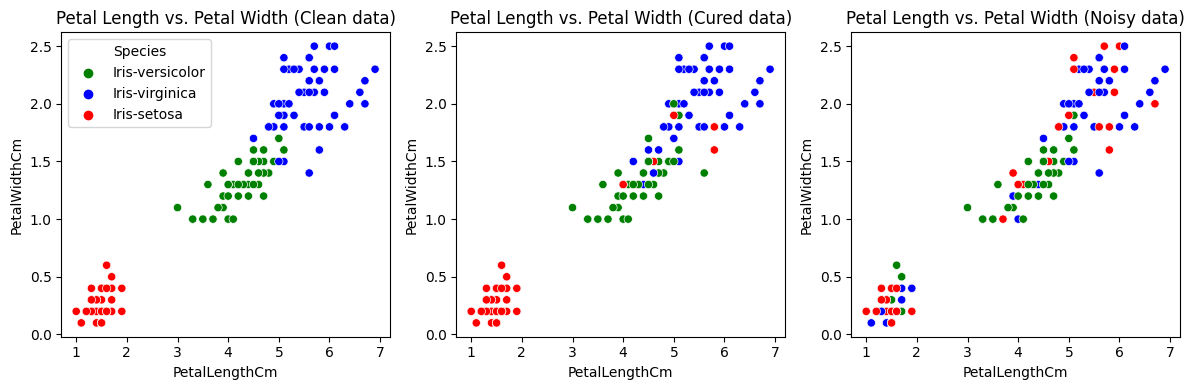

In [22]:
fig = plt.figure(figsize=(12, 4))  # Create a figure

ax1 = plt.subplot(131)
sns.scatterplot(data=clean_iris, x="PetalLengthCm", y="PetalWidthCm", hue="Species", palette=color_mapping, ax=ax1)
ax1.set_title("Petal Length vs. Petal Width (Clean data)")

color_mapping_noise = {1: "green", 2: "blue", 0: "red"}

ax2 = plt.subplot(132)
sns.scatterplot(data=noisy_df, x="PetalLengthCm", y="PetalWidthCm", hue="docta_labels", palette=color_mapping_noise,  ax=ax2, legend=False)
ax2.set_title("Petal Length vs. Petal Width (Cured data)")

ax3 = plt.subplot(133)
sns.scatterplot(data=noisy_df, x="PetalLengthCm", y="PetalWidthCm", hue="target", palette=color_mapping_noise,  ax=ax3, legend=False)
ax3.set_title("Petal Length vs. Petal Width (Noisy data)")

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

#### 2.5 Suggestions

**Suggestions for using Docta to diagnose your own tabular data:**

* Please set data_root in the config file appropriately

* Pre-process your tabular data accordingly

* For more information, functions, and better solutions that Docta provides, please email to **contact@docta.ai.**

**Suggestions for your follow up options:**

* **Option 1**: you may want to use the docta cured labels

    Simply by replacing y_train by y_cured above

* **Option 2**: you may also want to remove detected wrong labels



### Section 3: Explore rare data patterns (Tabular) with Docta

#### 3.1  What are long-tail samples?

A figure below illustrates what are high-frequency features and long-tailed features.

Long-tailed features appear to have a low-frequency in the data and tend to be under-fitted by the deep neural nets. Hence, bad performed.

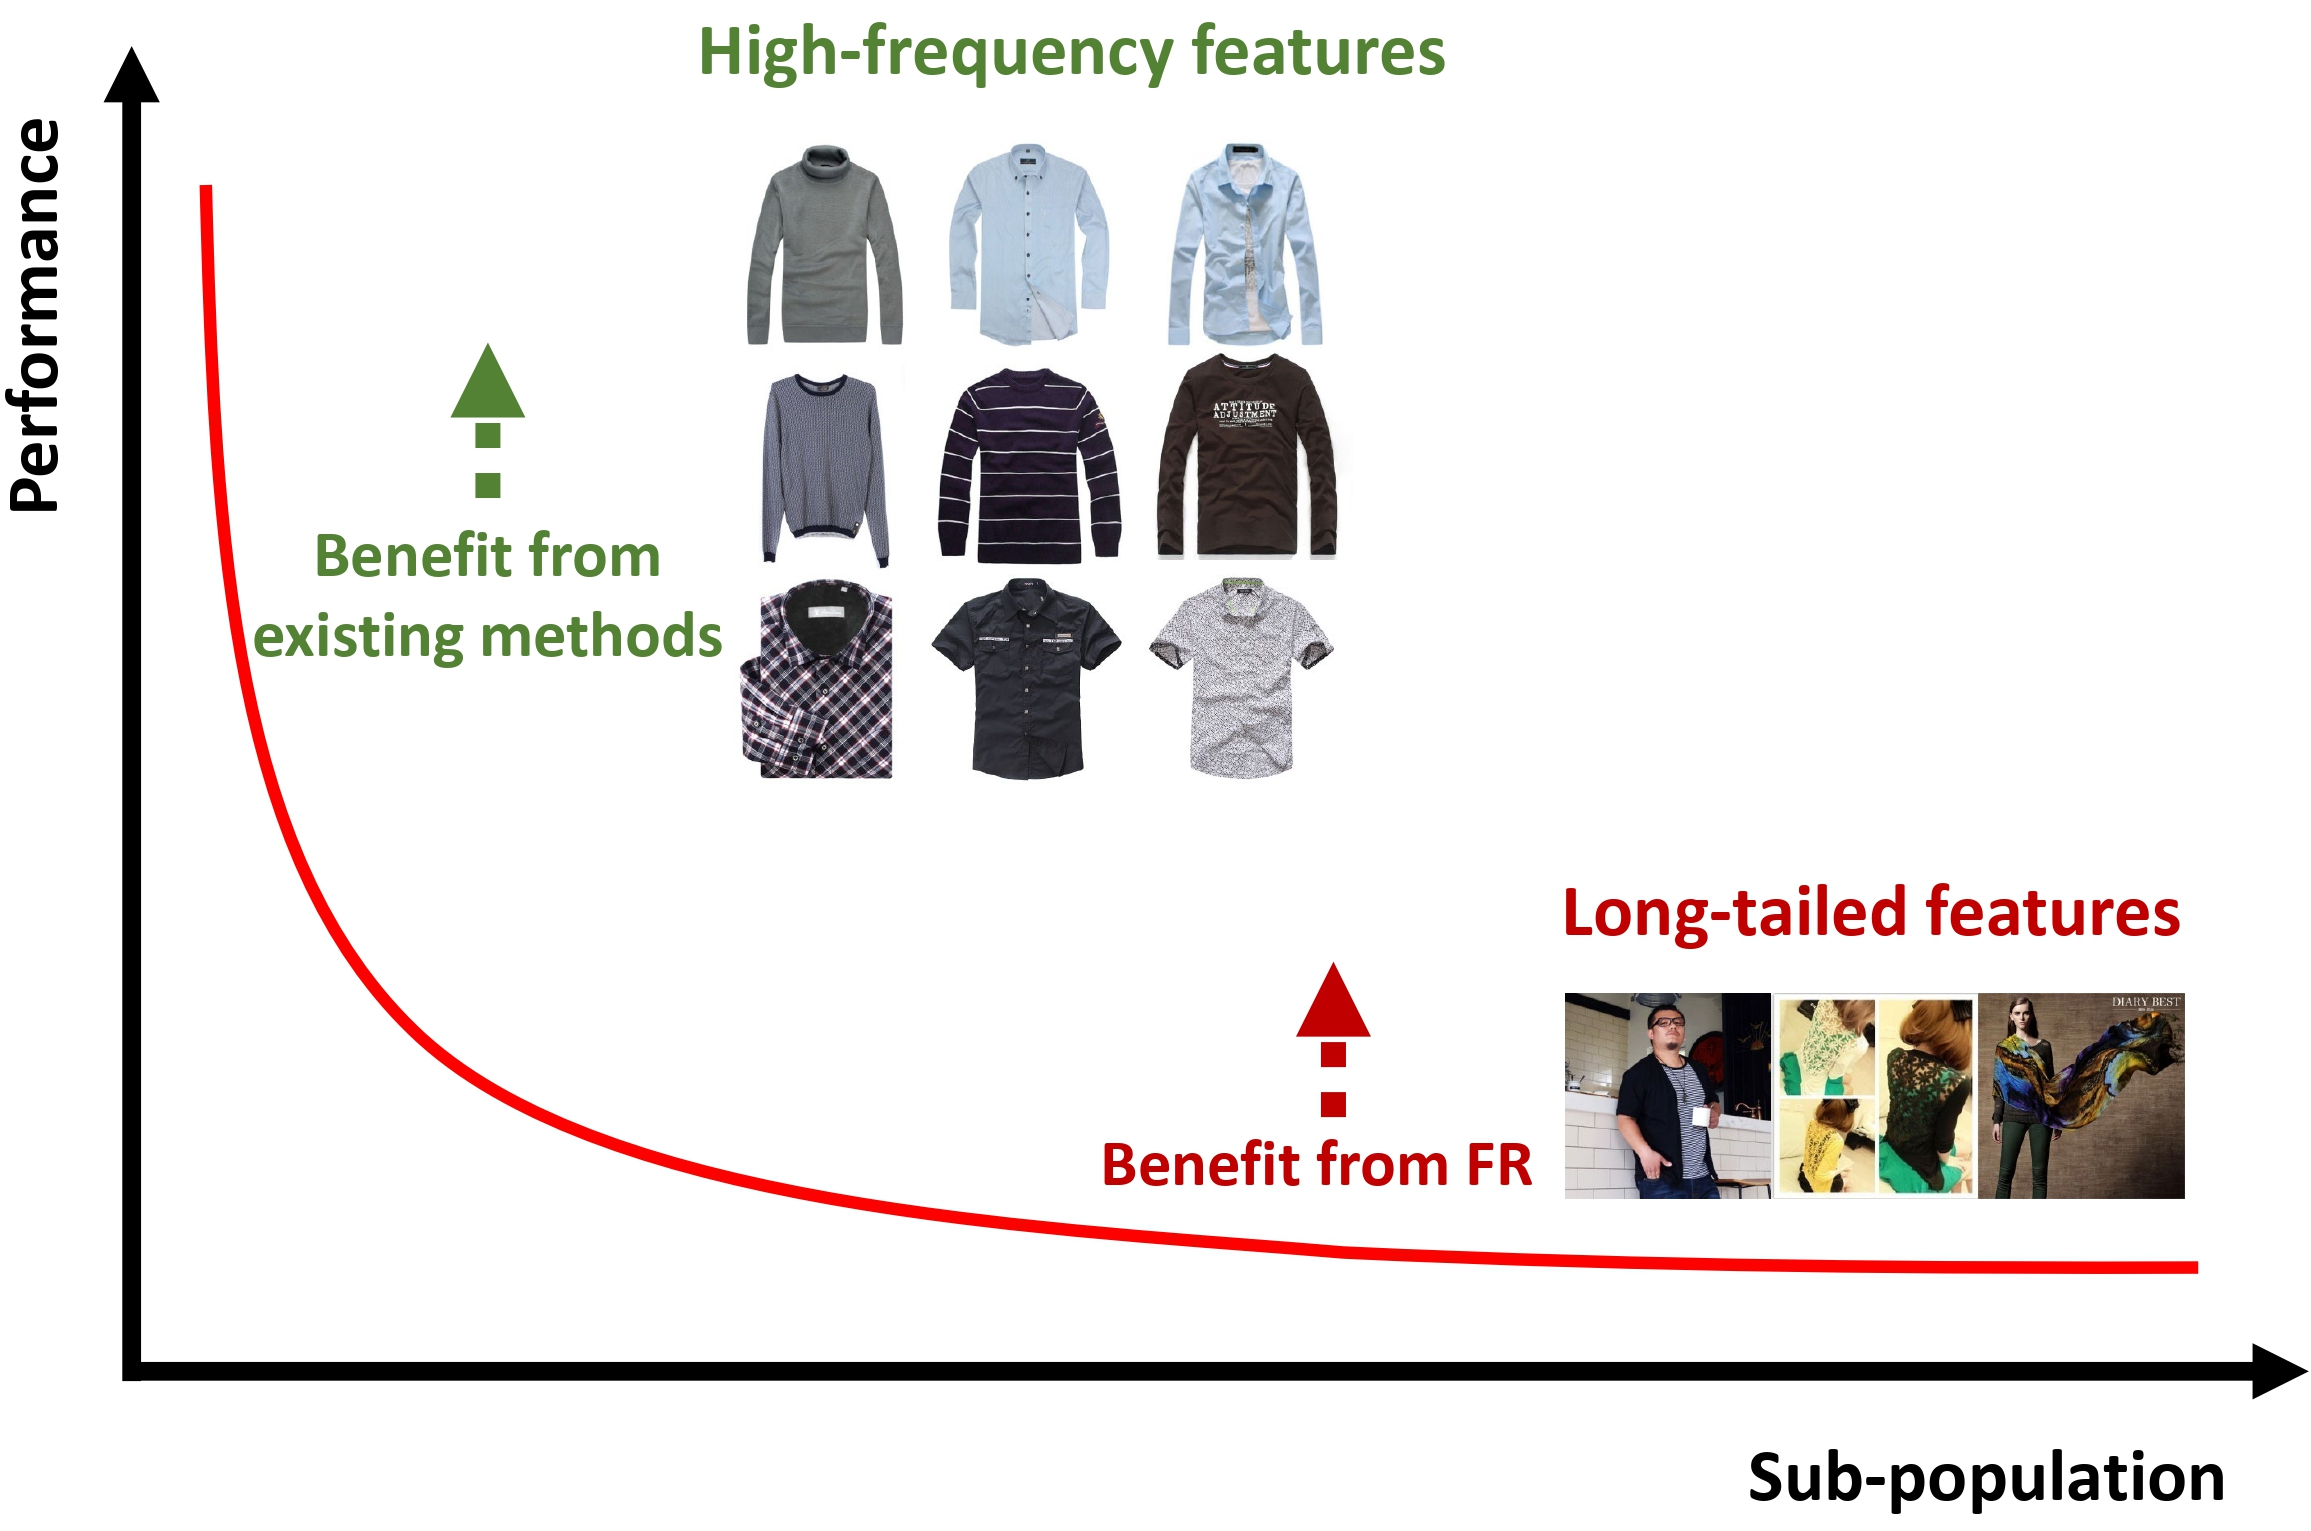

In [23]:
display(Image(filename='demo_imgs/long-tail-sample.jpg', width = 600, height = 400))

#### 3.2 Rare pattern detection for your tabular data with Docta

In [24]:
%run ./tools/docta_tabular_rare_pattern.py --suffix 'tabular'

Customizing the extracted embeddings as a dataset...
Getting consensus patterns...
Long-tail score saved to ./results/Tabular/embedding.csv


#### 3.3 Walk through the diagnose report given by Docta

Take a look at the long-tail scores and samples

In [25]:
import pandas as pd
lt_score_embedd = pd.read_csv('./results/Tabular/embedding.csv')
lt_score_embedd.head()

,idx,longtail_scores
0,0,0.0137
1,1,0.0263
2,2,0.0142
3,3,0.0031
4,4,0.0038


In [26]:
# A help function for results printing
from docta.datasets import TabularDataset
from docta.utils.config import Config
cfg = Config.fromfile(f'./config/lt_tabular.py')
dataset = TabularDataset(root_path=cfg.data_root)

def print_lt(idxs, cfg):
    df = pd.read_csv(cfg.data_root)
    for idx in idxs:
        print(f"Index: {idx}, data sample: {df.iloc[idx]}")

See some rare data

In [27]:
num_show = 1
lt_score = lt_score_embedd['longtail_scores'].tolist()
topN = sorted(range(len(lt_score)), key = lambda sub: lt_score[sub])[-num_show:]
print_lt(idxs=topN, cfg=cfg)
# Print out the fatures and the label (target) of a long-tail sample.

Index: 41, data sample: SepalLengthCm    5.7
SepalWidthCm     3.0
PetalLengthCm    4.2
PetalWidthCm     1.2
target           1.0
Name: 41, dtype: float64


The distribution of the per-sample long-tail scores

<Axes: >

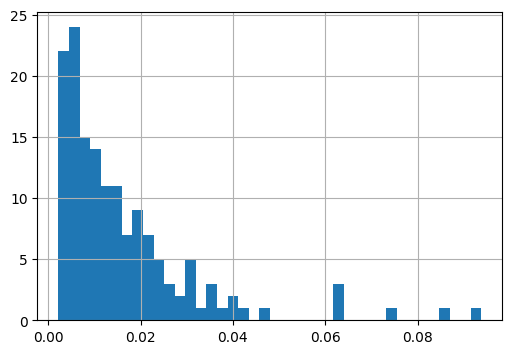

In [28]:
lt_score_embedd['longtail_scores'].hist(bins=40, figsize=[6,4])

In [29]:
clean_iris['lt_score'] = lt_score_embedd['longtail_scores'].tolist()

0.0338
14


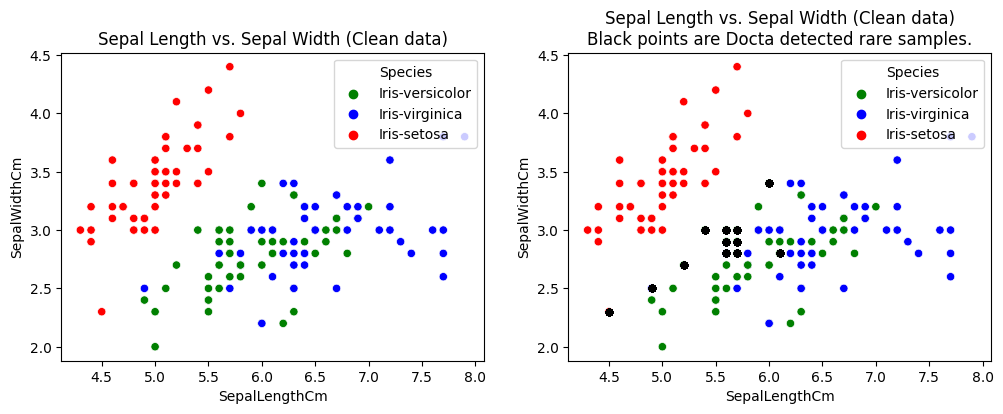

In [30]:
sorted_values = sorted(lt_score_embedd['longtail_scores'])
# Calculate the index for the top 10% values
top_10_percent_index = int(len(sorted_values) * 0.1)
# Extract the smallest top 20% values using list slicing
# Threshold of lt_score for top 10% long-tail samples
t = sorted_values[-top_10_percent_index]
print(t)
fig = plt.figure(figsize=(12, 4))
ax1 = plt.subplot(121)
sns.scatterplot(data=clean_iris, x="SepalLengthCm", y="SepalWidthCm", hue="Species", palette=color_mapping, ax=ax1)
ax1.set_title("Sepal Length vs. Sepal Width (Clean data)")


# Basic scatter plot
ax2 = plt.subplot(122)
# sns.scatterplot(data=clean_iris, x="SepalLengthCm", y="SepalWidthCm", hue="Species", marker='D', palette=color_mapping, alpha=0.3, ax=ax2)
sns.scatterplot(data=clean_iris, x="SepalLengthCm", y="SepalWidthCm", hue="Species", palette=color_mapping, ax=ax2)

mask = clean_iris['lt_score'] > t
lt_iris = clean_iris[mask]
print(len(lt_iris))
# Add '*' symbol for points with score larger than threshold 't'
for index, row in clean_iris.iterrows():
    ax2.scatter(lt_iris['SepalLengthCm'], lt_iris['SepalWidthCm'], color='black', s=20)
ax2.set_title("Sepal Length vs. Sepal Width (Clean data)\nBlack points are Docta detected rare samples.")
plt.show()

Since Docta detects rare samples without using the label information, 

it worths noting that Docta detects long-tail samples that are potentially far from the core datasets,

while may have large impacts on the model decision (near the decision boundary).